## Hidden Semi-Markov Model 

In [2]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from plot_utils import *
from mixture_model import *
%load_ext autoreload
%autoreload 2

#### Load Data 

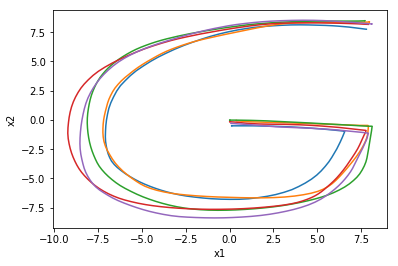

In [3]:
ROOT = '../python_data/2Dletters/'
n_samples = 5 #number of demonstrations
data = np.load(ROOT + 'G.npy')[:n_samples]
data = data.transpose([0,2,1])

#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-')
plt.xlabel('x1')
plt.ylabel('x2')

T = data.shape[1] #the number of timesteps for each trajectory
D = data.shape[2] #the number of dimensions

### Fit HSMM to the data 

In [4]:
hsmm = HSMM(D=D,K=5)
hsmm.fit(data,init_type='kmeans')
clear_output()

#compute the state duration probability
hsmm.compute_durations(hsmm.xs)

#remove the probability of self transition
hsmm.edit_trans()

#### Plot the mixture components 

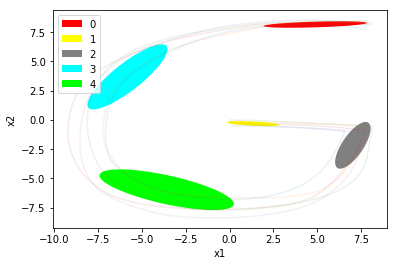

In [5]:
fig,ax = plt.subplots()
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
plot_GMM(hsmm.means_,hsmm.covariances_,ax,colors=colors,labels=range(6))
#plot data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-', alpha=0.1)
plt.xlabel('x1')
plt.ylabel('x2')


plt.legend()

### Computing the forward variables, based on a given data 

The forward variable $\alpha_{t,i}$ corresponds to the probability of belonging to the state $i$, given the observation from time 1 to $t$.  

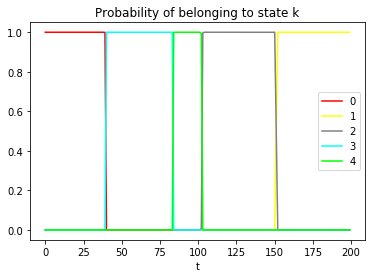

In [6]:
alpha,_ = hsmm.compute_forward_messages_HSMM(data[1])
for k in range(hsmm.K):
    plt.plot(alpha[:,k],color=colors[k], label=k)
plt.legend()
plt.title('Probability of belonging to state k')
plt.xlabel('t')
plt.show()

## Comparing GMM, HMM and HSMM 

All the three techniques can be used to fit the same data, to obtain similar mixture of Gaussian components. The main differences are:
- GMM does not model the transition probability between the states
- HMM model the transition probability, but the state duration is not specifically coded. Self-transition is coded as simply another transition probability. 
- HSMM model the state duration explicitly, i.e. how long we should stay at a particular state. It can be deterministic, i.e. setting a specific number of time steps, or probabilistic, i.e. setting a probability of state duration. Here we model the state duration as a Gaussian distribution, but other choices are also possible. 

In the following example, our data is composed of a concatenation of two letters, X and C. The dimension of the datapoints becomes four: the first two belong to the letter X, and the next two belong to the letter C.

We consider the first letter as 'input', and the second letter as 'output'. 

#### Load Data 

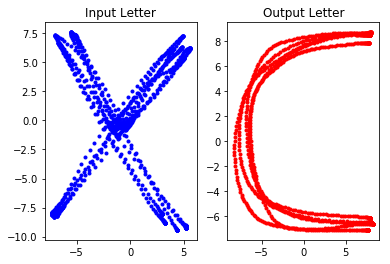

In [7]:
ROOT = '../python_data/2Dletters/'
data_in = np.load(ROOT + 'X.npy')[:5].transpose([0,2,1])
#data_in = np.random.randn(5,200,2)
data_out = np.load(ROOT + 'C.npy')[:5].transpose([0,2,1])
data = np.concatenate([data_in,data_out],axis=2)

colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]


T = data.shape[1] #number of time steps
D = data.shape[2] #number of dimensions

plt.subplot(1,2,1)
plt.title('Input Letter')
plt.subplot(1,2,2)
plt.title('Output Letter')

for data_i in data:
    plt.subplot(1,2,1)
    plt.plot(data_i[:,0], data_i[:,1],'.b')
    plt.subplot(1,2,2)
    plt.plot(data_i[:,2], data_i[:,3],'.r')

Our problem is as follow. We have five examples of two letters X and C, drawn simultaneously. By learning from this data, this is what we want to do: if we are given a new data of letter X as input, can we infer the output correctly? (i.e. to draw the letter C)

We want to do this by training GMM/HMM/HMM, and obtain the output by conditioning on the input.

#### Train GMM, HMM and HSMM 

In [24]:
gmm = GMM(D=D,K=5, M=1,N=5*200)
gmm.fit(data.reshape(-1,D),init_type='kmeans',max_iter = 50,n_init = 5)
clear_output()

In [9]:
hmm = HMM(D=D,K=5,M=5,N=200)
hmm.fit(data,init_type='kbins')
clear_output()

In [10]:
hsmm = HSMM(D=D,K=5,M=5,N=200)
hsmm.fit(data,init_type='kbins')
clear_output()

hsmm.compute_durations(hsmm.xs) #compute the state duration probability
hsmm.edit_trans() #remove the self-transition probability

#### Plot the input marginal distribution

Text(0.5,1,'HSMM')

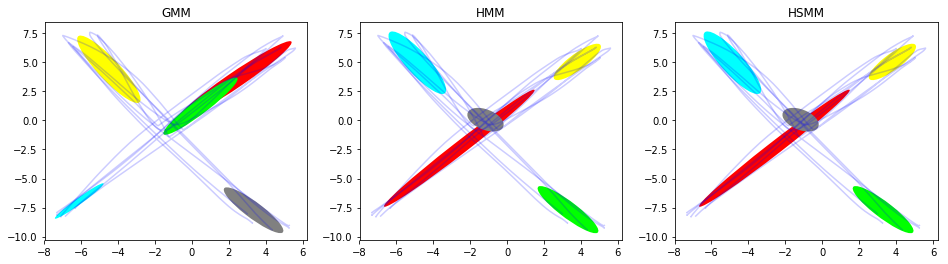

In [25]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(16,4)

for data_i in data:
    ax[0].plot(data_i[:,0], data_i[:,1],'-b', alpha=0.2)
    ax[1].plot(data_i[:,0], data_i[:,1],'-b', alpha=0.2)
    ax[2].plot(data_i[:,0], data_i[:,1],'-b', alpha=0.2)
    
plot_GMM(gmm.means_[:,0:2],gmm.covariances_[:,0:2,0:2],ax[0],colors=colors)
ax[0].set_title('GMM')

plot_GMM(hmm.means_[:,0:2],hmm.covariances_[:,0:2,0:2],ax[1],colors=colors)
ax[1].set_title('HMM')

plot_GMM(hsmm.means_[:,0:2],hsmm.covariances_[:,0:2,0:2],ax[2],colors=colors)
ax[2].set_title('HSMM')

#### Plot the output marginal distribution 

Text(0.5,1,'HSMM')

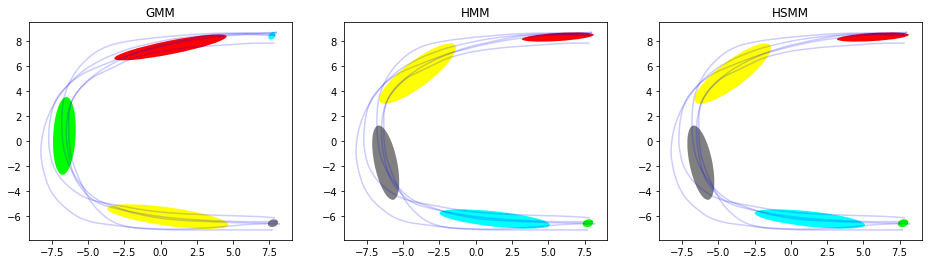

In [26]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(16,4)

for data_i in data:
    ax[0].plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)
    ax[1].plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)
    ax[2].plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)

plot_GMM(gmm.means_[:,2:],gmm.covariances_[:,2:,2:],ax[0],colors=colors)
ax[0].set_title('GMM')

plot_GMM(hmm.means_[:,2:],hmm.covariances_[:,2:,2:],ax[1],colors=colors)
ax[1].set_title('HMM')

plot_GMM(hsmm.means_[:,2:],hsmm.covariances_[:,2:,2:],ax[2],colors=colors)
ax[2].set_title('HSMM')

### Conditioning on the input

Now, given the input letter X, we want to compute the output by doing conditioning on our model. We assume that the input is given sequentially at each time step. 

#### GMM conditioning 

In [27]:
#compute the probabilities belonging to each state
alpha = np.zeros((data_in.shape[1], gmm.K))

Text(0.5,1,'GMM Reconstruction')

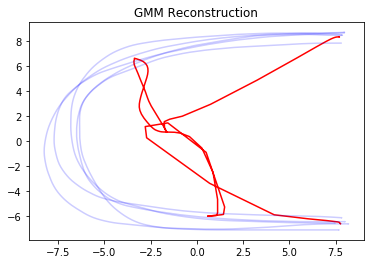

In [50]:
data_pred = []
for i,x_i in enumerate(data_in[2]):
    h,mu,sigma = gmm.condition(x_i[None,:],dim_in=slice(0,2),dim_out=slice(2,4),return_gmm=True)
    pred,cov = gmm.moment_matching(h,mu,sigma)
    alpha[i,:] = h
    data_pred  += [pred]
data_pred = np.asarray(data_pred)
plt.plot(data_pred[:,0],data_pred[:,1],'-r')
for data_i in data:
    plt.plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)
plt.title('GMM Reconstruction')

Text(0.5,0,'t')

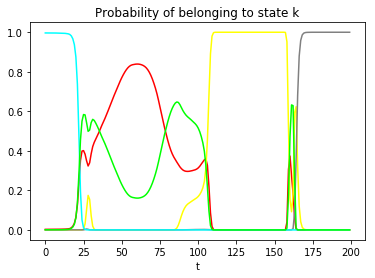

In [51]:
for k in range(gmm.K):
    plt.plot(alpha[:,k],color=colors[k])
plt.title('Probability of belonging to state k')
plt.xlabel('t')


#### HMM Conditioning 

In [52]:
data_pred = []
_,alpha,_,_,_,_,_ = hmm.compute_messages(data_in[0],obs_slice=slice(0,2))
data_pred= hmm.condition(data_in[2],dim_in=slice(0,2),dim_out=slice(2,4))
data_pred = np.asarray(data_pred)
clear_output()

Text(0.5,0,'t')

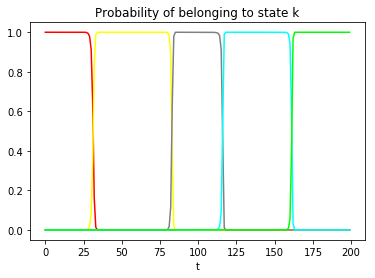

In [53]:
for k in range(hmm.K):
    plt.plot(alpha[:,k],color=colors[k])
plt.title('Probability of belonging to state k')
plt.xlabel('t')


Text(0.5,1,'HMM Reconstruction')

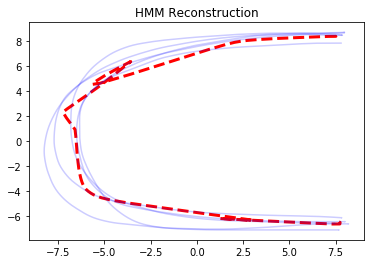

In [54]:
plt.plot(data_pred[:,0],data_pred[:,1],'r--',lw=3)
for data_i in data:
    plt.plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)
plt.title('HMM Reconstruction')

#### HSMM conditioning 

In [55]:
alpha,_ = hsmm.compute_forward_messages_HSMM(data_in[2],obs_slice=slice(0,2))
data_pred = []
data_pred= hsmm.condition(data_in[2],dim_in=slice(0,2),dim_out=slice(2,4))
data_pred = np.asarray(data_pred)
clear_output()

Text(0.5,0,'t')

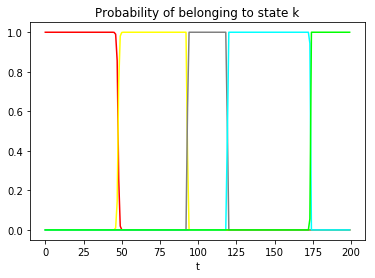

In [56]:
for k in range(hmm.K):
    plt.plot(alpha[:,k],color=colors[k])
plt.title('Probability of belonging to state k')
plt.xlabel('t')

Text(0.5,1,'HSMM Reconstruction')

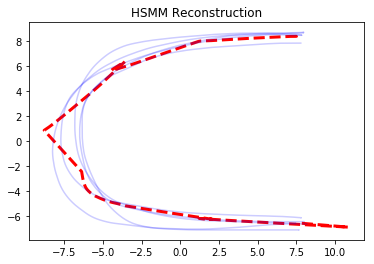

In [57]:
plt.plot(data_pred[:,0],data_pred[:,1],'r--',lw=3)
for data_i in data:
    plt.plot(data_i[:,2], data_i[:,3],'-b', alpha=0.2)
plt.title('HSMM Reconstruction')

### Discussion 

***

We see that when conditioning on GMM, we do not obtain good result. This is because the input letter X is ambiguous; at the middle of the letter X, the trajectory branches to two possible directions. Given this point in the middle, we cannot infer the possible current time steps accurately, so the output is really bad. If the input letter does not contain any ambiguity, GMM conditioning will performs well. (You can confirm this by changing the input data to other letters, e.g. 'G')

This does not happen with HMM and HSMM, because they encode the transition probability between the states. 



***

To see the difference between HMM and HSMM, you can modify the input data to be random data generated from a Gaussian distribution, instead of a letter X, and observe the result. You can do this by uncommenting the following line from the 'Load Data' section:

__data_in = np.random.randn(5,200,2)__



HMM here will perform badly, because there is no good correlation between the input and the output; Given the input, we cannot infer the output very well. 

HSMM, on the other hand, still performs well, because it encodes the state duration explicitly. 